In [1]:
#Import libraries
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
concatenate, Activation, dot, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [4]:
#Import data
dataset = pd.read_csv("../Data/final_data.csv", index_col="date")

In [29]:
values = dataset.values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled_t = scaled[:,-2]
scaled_tr = scaled.copy()
lag_t = 4
reframed = pd.DataFrame(scaled_tr)
reframed = reframed.shift(-lag_t).dropna()
reframed.columns = dataset.columns
reframed["cases_t"] = scaled_t[:-lag_t]
reframed.head()

,dengue,sintomas dengue,dolor de cabeza,migrana,dolor muscular,dolor ojos,nauseas,vomito,mosquito,picadura mosquito,mosquito dengue,dengue hemorragico,mosquitos,dolor huesos,dolor articulaciones,brote,cases,Rt,cases_t
0,0.231018,0.142300,0.263158,0.312044,0.216165,0.244541,0.000000,0.170648,0.000000,0.244541,0.335150,0.124661,0.174216,0.305913,0.246914,0.464419,0.082707,1.0,0.021008
1,0.150242,0.000000,0.271382,0.206204,0.086466,0.165939,0.174216,0.056314,0.309942,0.165939,0.057221,0.000000,0.078397,0.267352,0.000000,0.295880,0.068996,1.0,0.041132
2,0.137318,0.510721,0.000000,0.153285,0.332707,0.572052,0.186411,0.112628,0.072125,0.572052,0.207084,0.398374,0.240418,0.447301,0.000000,0.093633,0.063025,1.0,0.060814
3,0.169628,0.214425,0.304276,0.317518,0.203008,0.375546,0.358885,0.000000,0.000000,0.375546,0.095368,0.089431,0.094077,0.043702,0.000000,0.000000,0.069659,1.0,0.061698
4,0.085622,0.448343,0.215461,0.186131,0.313910,0.128821,0.106272,0.170648,0.187135,0.128821,0.117166,0.121951,0.000000,0.000000,0.246914,0.192884,0.066563,1.0,0.082707


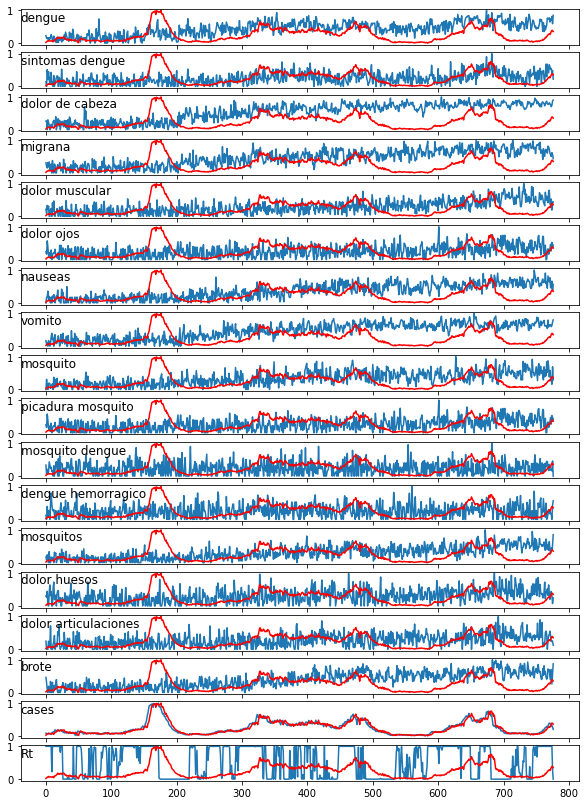

In [30]:
values = reframed.values
i = 1
plt.figure(figsize=(10,15))
for group in range(0,values.shape[1]-1):
    plt.subplot(values.shape[1], 1, i)
    plt.plot(values[:, group])
    plt.plot(values[:, -1], color="r")
    plt.title(dataset.columns[group], y = 0.5, loc='left')
    i += 1
plt.show()

In [33]:
values   = reframed.values[:,:17]
values_t = reframed.values[:,-1]#(rt_test["R"]>1).astype(int).values
n_train_weeks = 9 * 53
n_val_weeks = 3 * 53
train_X, train_y = values[:n_train_weeks, :], values_t[:n_train_weeks]
val_X, val_y = values[n_train_weeks:n_train_weeks+n_val_weeks, :], values_t[n_train_weeks:n_train_weeks+n_val_weeks]
test_X, test_y = values[n_train_weeks+n_val_weeks:, :], values_t[n_train_weeks+n_val_weeks:]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(477, 1, 17) (477,) (159, 1, 17) (159,) (141, 1, 17) (141,)


Epoch 1/50
7/7 - 11s - loss: 0.2378 - val_loss: 0.1140
Epoch 2/50
7/7 - 0s - loss: 0.1374 - val_loss: 0.1659
Epoch 3/50
7/7 - 0s - loss: 0.1311 - val_loss: 0.2242
Epoch 4/50
7/7 - 0s - loss: 0.1335 - val_loss: 0.2311
Epoch 5/50
7/7 - 0s - loss: 0.1363 - val_loss: 0.2039
Epoch 6/50
7/7 - 0s - loss: 0.1262 - val_loss: 0.1775
Epoch 7/50
7/7 - 0s - loss: 0.1241 - val_loss: 0.1692
Epoch 8/50
7/7 - 0s - loss: 0.1210 - val_loss: 0.1698
Epoch 9/50
7/7 - 0s - loss: 0.1187 - val_loss: 0.1747
Epoch 10/50
7/7 - 0s - loss: 0.1188 - val_loss: 0.1827
Epoch 11/50
7/7 - 0s - loss: 0.1126 - val_loss: 0.1793
Epoch 12/50
7/7 - 0s - loss: 0.1117 - val_loss: 0.1672
Epoch 13/50
7/7 - 0s - loss: 0.1125 - val_loss: 0.1565
Epoch 14/50
7/7 - 0s - loss: 0.1064 - val_loss: 0.1591
Epoch 15/50
7/7 - 0s - loss: 0.1035 - val_loss: 0.1574
Epoch 16/50
7/7 - 0s - loss: 0.1039 - val_loss: 0.1524
Epoch 17/50
7/7 - 0s - loss: 0.1057 - val_loss: 0.1498
Epoch 18/50
7/7 - 0s - loss: 0.1013 - val_loss: 0.1502
Epoch 19/50
7/7 - 

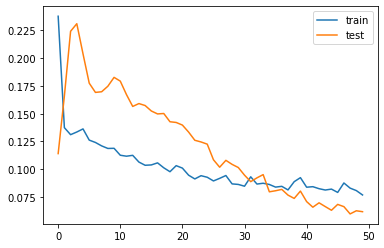

In [34]:
model = Sequential()
model.add(LSTM(100, dropout = 0.2, recurrent_dropout=0.2, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(val_X, val_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [35]:
yhat = model.predict(test_X)
sqrt(mean_squared_error(yhat, test_y))

0.0982589576544056

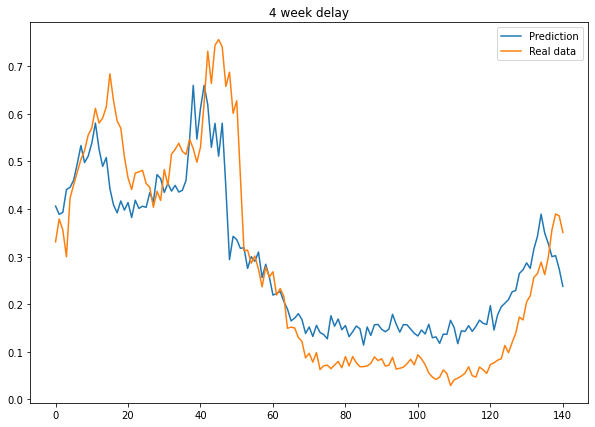

In [37]:
plt.figure(figsize=(10,7))
plt.plot(yhat, label='Prediction')
plt.plot(test_y, label = 'Real data')
plt.legend()
plt.title(str(lag_t)+' week delay')
plt.show()

# Segundo modelo

In [38]:
values   = reframed.values[:,:17]
values_t = reframed.values[:,-1]
n_train_weeks = 9 * 53
n_val_weeks = 3 * 53
train_X, train_y = values[:n_train_weeks, :], values_t[:n_train_weeks]
val_X, val_y = values[n_train_weeks:n_train_weeks+n_val_weeks, :], values_t[n_train_weeks:n_train_weeks+n_val_weeks]
test_X, test_y = values[n_train_weeks+n_val_weeks:, :], values_t[n_train_weeks+n_val_weeks:]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
val_X = val_X.reshape((val_X.shape[0], val_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
train_y = np.expand_dims(np.expand_dims(train_y, -1),-1)
val_y = np.expand_dims(np.expand_dims(val_y, -1),-1)
test_y = np.expand_dims(np.expand_dims(test_y, -1),-1)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(477, 17, 1) (477, 1, 1) (159, 17, 1) (159, 1, 1) (141, 17, 1) (141, 1, 1)


In [39]:
n_hidden = 100
input_train = Input(shape=(train_X.shape[1], train_X.shape[2]))
output_train = Input(shape=(1, 1))
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h) 
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
               return_state=False, return_sequences=True)(
    decoder_input, initial_state=[encoder_last_h, encoder_last_c])
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
decoder_combined_context = concatenate([context, decoder_stack_h])
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 17, 1)]      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 17, 100), (N 40800       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         lstm_1[0][1]                     
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 1, 100)       0           batch_normalization[0][0]        
______________________________________________________________________________________________

C:\Users\Windows\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [40]:
epc = 50
es = EarlyStopping(monitor='val_loss', mode='min', patience=int(epc/4))
history = model.fit(train_X, train_y, epochs=epc, batch_size=72, validation_data=(val_X, val_y), verbose=2, callbacks=[es], shuffle=True)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

Epoch 1/50
7/7 - 6s - loss: 0.6364 - mae: 0.5217 - val_loss: 0.0390 - val_mae: 0.1386
Epoch 2/50
7/7 - 1s - loss: 0.0481 - mae: 0.1692 - val_loss: 0.0154 - val_mae: 0.1055
Epoch 3/50
7/7 - 1s - loss: 0.0284 - mae: 0.1200 - val_loss: 0.0084 - val_mae: 0.0773
Epoch 4/50
7/7 - 1s - loss: 0.0294 - mae: 0.1215 - val_loss: 0.0330 - val_mae: 0.1641
Epoch 5/50
7/7 - 1s - loss: 0.0179 - mae: 0.0924 - val_loss: 0.0114 - val_mae: 0.0943
Epoch 6/50
7/7 - 1s - loss: 0.0174 - mae: 0.0933 - val_loss: 0.0120 - val_mae: 0.0978
Epoch 7/50
7/7 - 1s - loss: 0.0131 - mae: 0.0780 - val_loss: 0.0073 - val_mae: 0.0744
Epoch 8/50
7/7 - 1s - loss: 0.0135 - mae: 0.0808 - val_loss: 0.0122 - val_mae: 0.0985
Epoch 9/50
7/7 - 1s - loss: 0.0129 - mae: 0.0844 - val_loss: 0.0051 - val_mae: 0.0593
Epoch 10/50
7/7 - 1s - loss: 0.0126 - mae: 0.0779 - val_loss: 0.0170 - val_mae: 0.1181
Epoch 11/50
7/7 - 1s - loss: 0.0100 - mae: 0.0721 - val_loss: 0.0239 - val_mae: 0.1395
Epoch 12/50
7/7 - 1s - loss: 0.0121 - mae: 0.0804 - 

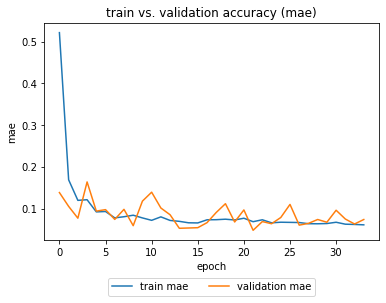

In [41]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [42]:
yhat = model.predict(test_X)
sqrt(mean_squared_error(yhat[:,0,0], test_y[:,0,0]))

0.1329109023701777

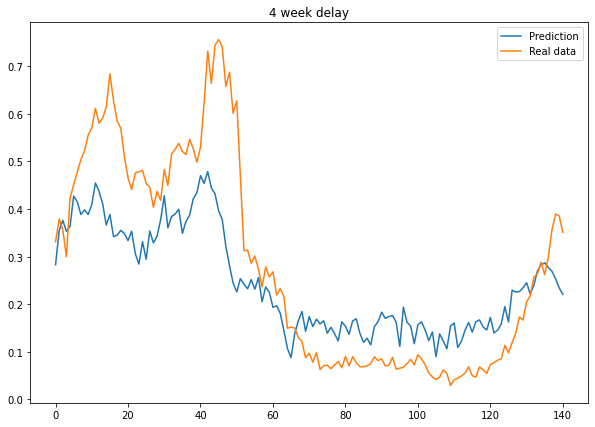

In [43]:
plt.figure(figsize=(10,7))
plt.plot(yhat[:,:,0], label='Prediction')
plt.plot(test_y[:,:,0], label = 'Real data')
plt.legend()
plt.title(str(lag_t)+' week delay')
plt.show()

# Tercer modelo

In [46]:
n_units = 100
dropout_rate = 0.2
learning_rate = 0.001
n_epochs = 50

# Build LSTM model
model = Sequential()
model.add(LSTM(units=n_units, input_shape=(train_X.shape[1], train_X.shape[2]), activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [47]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=int(n_epochs/2))
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=32, verbose=2, validation_data=(val_X, val_y))
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

Epoch 1/50
15/15 - 2s - loss: 0.0867 - mae: 0.2101 - val_loss: 0.0319 - val_mae: 0.1604
Epoch 2/50
15/15 - 1s - loss: 0.0432 - mae: 0.1598 - val_loss: 0.0402 - val_mae: 0.1801
Epoch 3/50
15/15 - 1s - loss: 0.0404 - mae: 0.1470 - val_loss: 0.0530 - val_mae: 0.2090
Epoch 4/50
15/15 - 1s - loss: 0.0384 - mae: 0.1453 - val_loss: 0.0412 - val_mae: 0.1826
Epoch 5/50
15/15 - 1s - loss: 0.0382 - mae: 0.1410 - val_loss: 0.0620 - val_mae: 0.2260
Epoch 6/50
15/15 - 1s - loss: 0.0375 - mae: 0.1408 - val_loss: 0.0529 - val_mae: 0.2083
Epoch 7/50
15/15 - 1s - loss: 0.0356 - mae: 0.1344 - val_loss: 0.0497 - val_mae: 0.2017
Epoch 8/50
15/15 - 1s - loss: 0.0354 - mae: 0.1344 - val_loss: 0.0597 - val_mae: 0.2208
Epoch 9/50
15/15 - 1s - loss: 0.0333 - mae: 0.1282 - val_loss: 0.0560 - val_mae: 0.2135
Epoch 10/50
15/15 - 1s - loss: 0.0338 - mae: 0.1286 - val_loss: 0.0613 - val_mae: 0.2234
Epoch 11/50
15/15 - 1s - loss: 0.0320 - mae: 0.1292 - val_loss: 0.0447 - val_mae: 0.1904
Epoch 12/50
15/15 - 1s - loss:

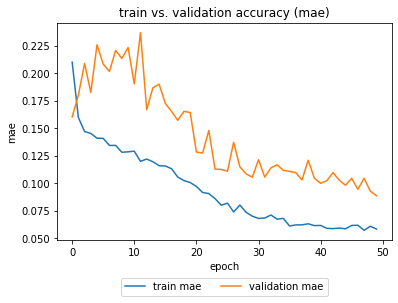

In [48]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [52]:
yhat = model.predict(test_X)
sqrt(mean_squared_error(yhat[:,0], test_y[:,0,0]))

0.12035141569411534

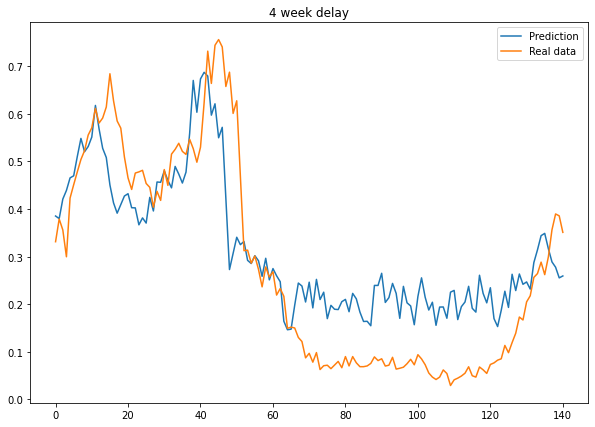

In [53]:
plt.figure(figsize=(10,7))
plt.plot(yhat[:,0], label='Prediction')
plt.plot(test_y[:,:,0], label = 'Real data')
plt.legend()
plt.title(str(lag_t)+' week delay')
plt.show()